In [53]:
# Import all dependencies
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
import sqlalchemy
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import datetime

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from imblearn.ensemble import BalancedRandomForestClassifier

In [10]:
# Load the data
cc_df = pd.read_csv("../climate_change_twitter.csv")
cc_df.head(5)

,created_at,id,lng,lat,topic,sentiment,stance,gender,temperature_avg,aggressiveness
0,2006-06-06 16:06:42+00:00,6132.0,NaN,NaN,Weather Extremes,-0.097180,neutral,female,NaN,aggressive
1,2006-07-23 21:52:30+00:00,13275.0,-73.949582,40.650104,Weather Extremes,0.575777,neutral,undefined,-1.114768,aggressive
2,2006-08-29 01:52:30+00:00,23160.0,NaN,NaN,Weather Extremes,0.500479,neutral,male,NaN,aggressive
3,2006-11-07 02:46:52+00:00,57868.0,NaN,NaN,Weather Extremes,0.032816,neutral,male,NaN,aggressive
4,2006-11-27 14:27:43+00:00,304553.0,NaN,NaN,Importance of Human Intervantion,-0.090428,neutral,male,NaN,aggressive


In [11]:
# Drop the null rows
cc_df = cc_df.dropna()
cc_df.head()

,created_at,id,lng,lat,topic,sentiment,stance,gender,temperature_avg,aggressiveness
1,2006-07-23 21:52:30+00:00,13275.0,-73.949582,40.650104,Weather Extremes,0.575777,neutral,undefined,-1.114768,aggressive
7,2006-12-14 01:39:10+00:00,1092823.0,-122.419420,37.774930,Ideological Positions on Global Warming,-0.544195,neutral,male,4.228540,aggressive
8,2006-12-17 19:43:09+00:00,1278023.0,-79.791980,36.072640,Weather Extremes,-0.565028,denier,male,5.478175,aggressive
9,2006-12-21 01:39:01+00:00,1455543.0,-121.805790,38.004920,Weather Extremes,0.650960,neutral,male,-1.652156,not aggressive
11,2006-12-31 10:47:25+00:00,1893063.0,-1.902691,52.479699,Weather Extremes,0.670905,neutral,male,4.864521,aggressive


In [12]:
# Get rid of spaces in names
cc_df.columns = cc_df.columns.str.strip()

In [5]:
# Drop ID column
# cc_df = cc_df.drop(["id"], axis=1)

In [13]:
# One hot encode topic, stance, gender, and aggressiveness to numerical values
encoded_df = pd.get_dummies(cc_df, columns=['topic', 'stance', 'gender', 'aggressiveness'])
encoded_df

,created_at,id,lng,lat,sentiment,temperature_avg,topic_Donald Trump versus Science,topic_Global stance,topic_Ideological Positions on Global Warming,topic_Impact of Resource Overconsumption,...,topic_Undefined / One Word Hashtags,topic_Weather Extremes,stance_believer,stance_denier,stance_neutral,gender_female,gender_male,gender_undefined,aggressiveness_aggressive,aggressiveness_not aggressive
1,2006-07-23 21:52:30+00:00,1.327500e+04,-73.949582,40.650104,0.575777,-1.114768,0,0,0,0,...,0,1,0,0,1,0,0,1,1,0
7,2006-12-14 01:39:10+00:00,1.092823e+06,-122.419420,37.774930,-0.544195,4.228540,0,0,1,0,...,0,0,0,0,1,0,1,0,1,0
8,2006-12-17 19:43:09+00:00,1.278023e+06,-79.791980,36.072640,-0.565028,5.478175,0,0,0,0,...,0,1,0,1,0,0,1,0,1,0
9,2006-12-21 01:39:01+00:00,1.455543e+06,-121.805790,38.004920,0.650960,-1.652156,0,0,0,0,...,0,1,0,0,1,0,1,0,0,1
11,2006-12-31 10:47:25+00:00,1.893063e+06,-1.902691,52.479699,0.670905,4.864521,0,0,0,0,...,0,1,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048528,2011-03-29 08:23:23+00:00,5.264700e+16,144.963320,-37.814000,-0.412735,1.822982,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
1048533,2011-03-29 08:42:01+00:00,5.265170e+16,110.828448,-7.569246,0.450944,-0.253280,0,0,1,0,...,0,0,0,0,1,1,0,0,0,1
1048551,2011-03-29 09:21:17+00:00,5.266160e+16,121.069917,14.528887,0.538100,-1.243056,0,0,0,0,...,0,1,0,0,1,0,1,0,0,1
1048558,2011-03-29 09:44:21+00:00,5.266740e+16,1.155450,52.059170,0.061093,1.056350,0,0,0,0,...,0,0,0,0,1,1,0,0,0,1


In [14]:
# Change latitude and longitude to zip codes
lat_lng_df = cc_df[['id','lat', 'lng']]
lat_lng_df

,id,lat,lng
1,1.327500e+04,40.650104,-73.949582
7,1.092823e+06,37.774930,-122.419420
8,1.278023e+06,36.072640,-79.791980
9,1.455543e+06,38.004920,-121.805790
11,1.893063e+06,52.479699,-1.902691
...,...,...,...
1048528,5.264700e+16,-37.814000,144.963320
1048533,5.265170e+16,-7.569246,110.828448
1048551,5.266160e+16,14.528887,121.069917
1048558,5.266740e+16,52.059170,1.155450


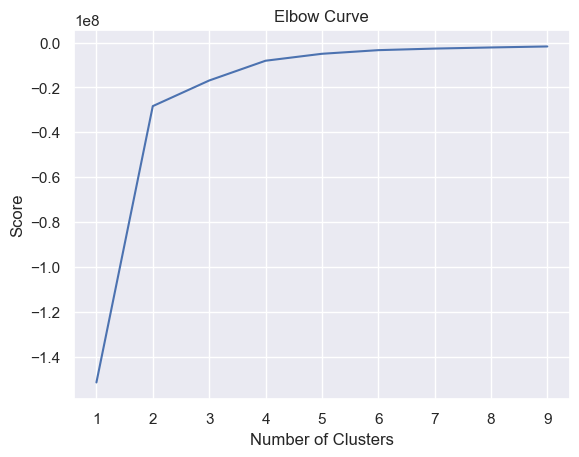

In [18]:
# Plot the elbow curve to find the optimal number of K clusters

K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]

Y_axis = lat_lng_df[['lat']]
X_axis = lat_lng_df[['lng']]

score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [21]:
kmeans = KMeans(n_clusters = 8, init ='k-means++')
# Compute k-means clustering.
kmeans.fit(lat_lng_df[lat_lng_df.columns[1:3]]) 
# Coordinates of cluster centers.
lat_lng_df['cluster_label'] = kmeans.fit_predict(lat_lng_df[lat_lng_df.columns[1:3]])
centers = kmeans.cluster_centers_ 
# Labels of each point
labels = kmeans.predict(lat_lng_df[lat_lng_df.columns[1:3]])
lat_lng_df.head(10)

C:\Users\leece\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,id,lat,lng,cluster_label
1,13275.0,40.650104,-73.949582,0
7,1092823.0,37.774930,-122.419420,4
8,1278023.0,36.072640,-79.791980,0
9,1455543.0,38.004920,-121.805790,4
11,1893063.0,52.479699,-1.902691,2
12,2266613.0,40.650104,-73.949582,0
15,2377823.0,51.508530,-0.125740,2
21,2579403.0,51.507322,-0.127647,2
22,2579433.0,51.507322,-0.127647,2
23,2604673.0,51.507322,-0.127647,2


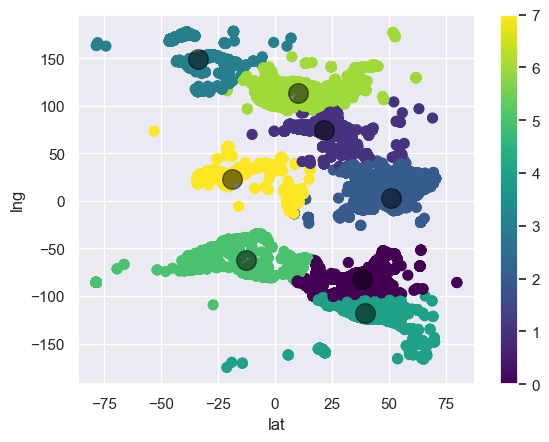

In [23]:
# Visualize the results

lat_lng_df.plot.scatter(x = 'lat', y = 'lng', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [63]:
# Print the centers
centers = kmeans.cluster_centers_
print(centers)

[[  38.25833694  -82.31349034]
 [  21.69074245   75.13614052]
 [  50.83078122    3.13087817]
 [ -33.91914468  149.50519002]
 [  39.5235599  -118.3948073 ]
 [ -12.47239823  -62.39777347]
 [  10.14030142  113.67940979]
 [ -18.86478812   23.10410606]]


In [51]:
# Find the zipcode of the centers using geopy

#Importing geopy
from geopy.geocoders import Nominatim
geocoder = Nominatim(user_agent = 'climate_project')

# Adding 1 second padding between calls
from geopy.extra.rate_limiter import RateLimiter
geocode = RateLimiter(geocoder.geocode, min_delay_seconds = 1,   return_value_on_exception = None) 

# Returns geopy Location object
reverse = RateLimiter(geocoder.reverse, min_delay_seconds=1)

# Initialize empty list to hold results
locations = []

# For loop to loop through the list of lat/lng
for i in range(8):
    locations.append(reverse(centers[(i)]))

# Print results
print(locations)

[Location(Beech Fork Road, Wayne County, West Virginia, 25512, United States, (38.255633, -82.318492, 0.0)), Location(SubCentre, Borli, NH52, Sendhwa Tahsil, Barwani, Madhya Pradesh, 451449, India, (21.6942556, 75.1332343, 0.0)), Location(169, Ieperstraat, Moorsele, Wevelgem, Kortrijk, West-Vlaanderen, Vlaanderen, 8560, België / Belgique / Belgien, (50.83139055, 3.134110826170213, 0.0)), Location(Bald Ridge Road, Bald Ridge, Burraga, Oberon Council, New South Wales, 2795, Australia, (-33.91725724591213, 149.5048766664451, 0.0)), Location(Churchill County, Nevada, United States, (39.6136309, -118.4191948, 0.0)), Location(São Francisco do Guaporé, Região Geográfica Imediata de Ji-Paraná, Região Geográfica Intermediária de Ji-Paraná, Rondônia, Região Norte, Brasil, (-12.3795766, -62.947262468698625, 0.0)), Location(Tỉnh Khánh Hòa, Việt Nam, (12.1960803, 108.9950386, 0.0)), Location(North-West District, Botswana, (-19.3893529, 23.267951, 0.0))]


In [52]:
# Get zipcode from raw locational data and pair with cluster label

In [24]:
# Prepare the data to be merged back to original df
X = lat_lng_df[['id','cluster_label']]
X.head(5)

,id,cluster_label
1,13275.0,0
7,1092823.0,4
8,1278023.0,0
9,1455543.0,4
11,1893063.0,2


In [25]:
# Look at encoded df
encoded_df.head()

,created_at,id,lng,lat,sentiment,temperature_avg,topic_Donald Trump versus Science,topic_Global stance,topic_Ideological Positions on Global Warming,topic_Impact of Resource Overconsumption,...,topic_Undefined / One Word Hashtags,topic_Weather Extremes,stance_believer,stance_denier,stance_neutral,gender_female,gender_male,gender_undefined,aggressiveness_aggressive,aggressiveness_not aggressive
1,2006-07-23 21:52:30+00:00,13275.0,-73.949582,40.650104,0.575777,-1.114768,0,0,0,0,...,0,1,0,0,1,0,0,1,1,0
7,2006-12-14 01:39:10+00:00,1092823.0,-122.419420,37.774930,-0.544195,4.228540,0,0,1,0,...,0,0,0,0,1,0,1,0,1,0
8,2006-12-17 19:43:09+00:00,1278023.0,-79.791980,36.072640,-0.565028,5.478175,0,0,0,0,...,0,1,0,1,0,0,1,0,1,0
9,2006-12-21 01:39:01+00:00,1455543.0,-121.805790,38.004920,0.650960,-1.652156,0,0,0,0,...,0,1,0,0,1,0,1,0,0,1
11,2006-12-31 10:47:25+00:00,1893063.0,-1.902691,52.479699,0.670905,4.864521,0,0,0,0,...,0,1,0,0,1,0,1,0,1,0


In [55]:
clustered_data_df = encoded_df.merge(X, left_on='id', right_on='id')
clustered_data_df.head(5)

,created_at,id,lng,lat,sentiment,temperature_avg,topic_Donald Trump versus Science,topic_Global stance,topic_Ideological Positions on Global Warming,topic_Impact of Resource Overconsumption,...,topic_Weather Extremes,stance_believer,stance_denier,stance_neutral,gender_female,gender_male,gender_undefined,aggressiveness_aggressive,aggressiveness_not aggressive,cluster_label
0,2006-07-23 21:52:30+00:00,13275.0,-73.949582,40.650104,0.575777,-1.114768,0,0,0,0,...,1,0,0,1,0,0,1,1,0,0
1,2006-12-14 01:39:10+00:00,1092823.0,-122.419420,37.774930,-0.544195,4.228540,0,0,1,0,...,0,0,0,1,0,1,0,1,0,4
2,2006-12-17 19:43:09+00:00,1278023.0,-79.791980,36.072640,-0.565028,5.478175,0,0,0,0,...,1,0,1,0,0,1,0,1,0,0
3,2006-12-21 01:39:01+00:00,1455543.0,-121.805790,38.004920,0.650960,-1.652156,0,0,0,0,...,1,0,0,1,0,1,0,0,1,4
4,2006-12-31 10:47:25+00:00,1893063.0,-1.902691,52.479699,0.670905,4.864521,0,0,0,0,...,1,0,0,1,0,1,0,1,0,2


In [58]:
#Isolate day from timestamp
clustered_data_df['created_at'] = pd.to_datetime(clustered_data_df['created_at'])
clustered_data_df['date'] = clustered_data_df['created_at'].dt.date
# clustered_data_df['time'] = clustered_data_df['created_at'].dt.time
clustered_data_df.head()

,created_at,id,lng,lat,sentiment,temperature_avg,topic_Donald Trump versus Science,topic_Global stance,topic_Ideological Positions on Global Warming,topic_Impact of Resource Overconsumption,...,stance_denier,stance_neutral,gender_female,gender_male,gender_undefined,aggressiveness_aggressive,aggressiveness_not aggressive,cluster_label,date,time
0,2006-07-23 21:52:30+00:00,13275.0,-73.949582,40.650104,0.575777,-1.114768,0,0,0,0,...,0,1,0,0,1,1,0,0,2006-07-23,21:52:30
1,2006-12-14 01:39:10+00:00,1092823.0,-122.419420,37.774930,-0.544195,4.228540,0,0,1,0,...,0,1,0,1,0,1,0,4,2006-12-14,01:39:10
2,2006-12-17 19:43:09+00:00,1278023.0,-79.791980,36.072640,-0.565028,5.478175,0,0,0,0,...,1,0,0,1,0,1,0,0,2006-12-17,19:43:09
3,2006-12-21 01:39:01+00:00,1455543.0,-121.805790,38.004920,0.650960,-1.652156,0,0,0,0,...,0,1,0,1,0,0,1,4,2006-12-21,01:39:01
4,2006-12-31 10:47:25+00:00,1893063.0,-1.902691,52.479699,0.670905,4.864521,0,0,0,0,...,0,1,0,1,0,1,0,2,2006-12-31,10:47:25


In [59]:
# Drop created_at column
clustered_data_df = clustered_data_df.drop('created_at', axis=1)

In [60]:
# Check dataframe
clustered_data_df.head()

,id,lng,lat,sentiment,temperature_avg,topic_Donald Trump versus Science,topic_Global stance,topic_Ideological Positions on Global Warming,topic_Impact of Resource Overconsumption,topic_Importance of Human Intervantion,...,stance_denier,stance_neutral,gender_female,gender_male,gender_undefined,aggressiveness_aggressive,aggressiveness_not aggressive,cluster_label,date,time
0,13275.0,-73.949582,40.650104,0.575777,-1.114768,0,0,0,0,0,...,0,1,0,0,1,1,0,0,2006-07-23,21:52:30
1,1092823.0,-122.419420,37.774930,-0.544195,4.228540,0,0,1,0,0,...,0,1,0,1,0,1,0,4,2006-12-14,01:39:10
2,1278023.0,-79.791980,36.072640,-0.565028,5.478175,0,0,0,0,0,...,1,0,0,1,0,1,0,0,2006-12-17,19:43:09
3,1455543.0,-121.805790,38.004920,0.650960,-1.652156,0,0,0,0,0,...,0,1,0,1,0,0,1,4,2006-12-21,01:39:01
4,1893063.0,-1.902691,52.479699,0.670905,4.864521,0,0,0,0,0,...,0,1,0,1,0,1,0,2,2006-12-31,10:47:25
